In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import pathlib
import cv2

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
training = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 500 files for training.


In [4]:
validation = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 124 files for validation.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

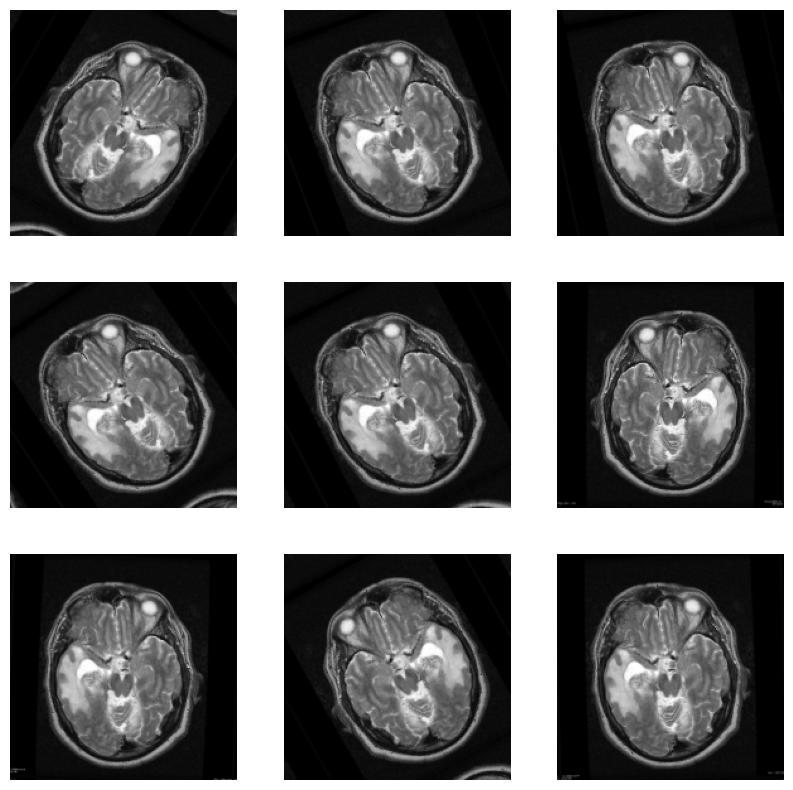

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in training.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
classes = training.class_names
print(classes)

['Astrocytoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']


In [8]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normlayer = layers.Rescaling(1./255)

In [12]:
normdata = training.map(lambda x, y: (normlayer(x), y))
image_batch, labels_batch = next(iter(normdata))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99842584


In [14]:
numclass = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numclass)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [17]:
epochs=19
history = model.fit(
  training,
  validation_data=validation,
  epochs=epochs)

Epoch 1/19
16/16 [==============================] - 10s 491ms/step - loss: 2.3984 - accuracy: 0.2560 - val_loss: 2.0541 - val_accuracy: 0.4113
Epoch 2/19
16/16 [==============================] - 7s 435ms/step - loss: 1.6420 - accuracy: 0.5220 - val_loss: 1.4192 - val_accuracy: 0.6048
Epoch 3/19
16/16 [==============================] - 7s 447ms/step - loss: 0.8538 - accuracy: 0.7600 - val_loss: 0.9153 - val_accuracy: 0.7339
Epoch 4/19
16/16 [==============================] - 7s 447ms/step - loss: 0.4126 - accuracy: 0.8880 - val_loss: 0.9907 - val_accuracy: 0.7581
Epoch 5/19
16/16 [==============================] - 7s 442ms/step - loss: 0.1847 - accuracy: 0.9520 - val_loss: 0.8734 - val_accuracy: 0.8306
Epoch 6/19
16/16 [==============================] - 7s 438ms/step - loss: 0.0609 - accuracy: 0.9900 - val_loss: 0.7757 - val_accuracy: 0.8790
Epoch 7/19
16/16 [==============================] - 7s 441ms/step - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.9039 - val_accuracy: 0.8468
Epoch

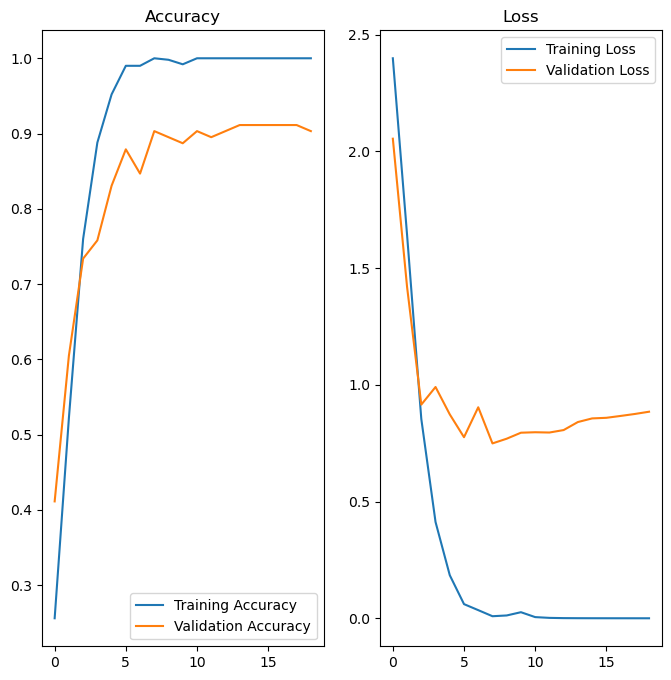

In [18]:
tacc = history.history['accuracy']
vacc = history.history['val_accuracy']

tloss = history.history['loss']
vloss = history.history['val_loss']

eprange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(eprange, tacc, label='Training Accuracy')
plt.plot(eprange, vacc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(eprange, tloss, label='Training Loss')
plt.plot(eprange, vloss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [19]:
def prediction(datpath, model):
    img_height, img_width = 180, 180
    im = tf.keras.utils.load_img(datpath, target_size=(img_height, img_width))
    imarray = tf.keras.utils.img_to_array(im)
    imarray = tf.expand_dims(imarray, 0) 
    predict = model.predict(imarray)
    classindex = np.argmax(predict[0])
    return classindex

In [20]:
model.save('my_model.keras')
loaded_model = tf.keras.models.load_model('model.h5')

In [21]:
dat = 'C:/Users/pragn/Downloads/dataset_T2MRI/Granuloma/a390b23ec3de409ae1ac468646ec81_big_gallery.jpeg'
mri = cv2.imread(dat)
classindex = prediction(dat, model)

1/1 [==============================] - 0s 243ms/step


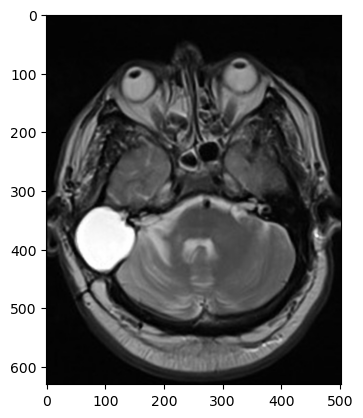

In [22]:
plt.imshow(mri)

In [23]:
seg = mri.reshape(-1, 3)
seg = np.float32(seg)

In [24]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_,labels,centers = cv2.kmeans(seg, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((mri.shape[:-1]))
redu = np.uint8(centers)[labels]

In [27]:
for i, c in enumerate(centers):
    mask = cv2.inRange(labels, i, i)
    mask = np.dstack([mask]*3) 
    tumor = cv2.bitwise_and(mri, mask)

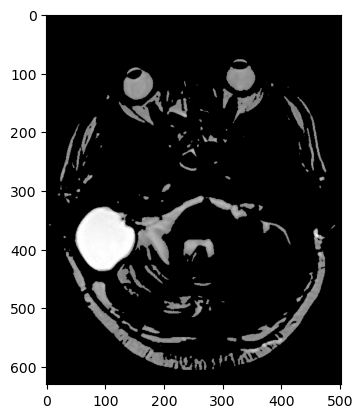

In [28]:
plt.imshow(tumor)

In [29]:
tum = tumor
grey = cv2.cvtColor(tum, cv2.COLOR_BGR2GRAY)
thresh = cv2.convertScaleAbs(grey)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
anomaly = max(contours, key=cv2.contourArea)

In [30]:
cv2.drawContours(tum, [anomaly], -1, (191, 54, 12), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

NEUROVISION SUMMARY
-------------------------------------------
INTRACRANIAL TUMOR TYPE: Granuloma
TUMOR IDENTIFICATION VALIDATION ACCURACY: 91.12903475761414 %
TUMOR IDENTIFICATION TRAINING ACCURACY: 100.0 %


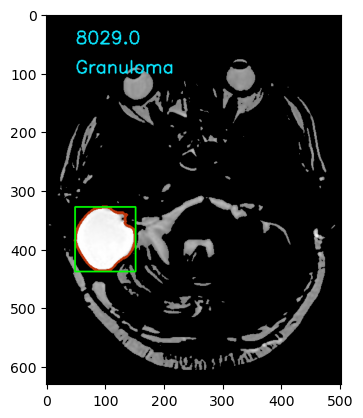

In [32]:
types = ['Astrocytoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
print("NEUROVISION SUMMARY")
print("-------------------------------------------")
print("INTRACRANIAL TUMOR TYPE: "+types[classindex])
systemvacc = max(vacc)
systemtacc = max(tacc)
print("TUMOR IDENTIFICATION VALIDATION ACCURACY: "+str(100*systemvacc)+' %')
print("TUMOR IDENTIFICATION TRAINING ACCURACY: "+str(100*systemtacc)+' %')

area = cv2.contourArea(anomaly)
x, y, w, h = cv2.boundingRect(anomaly) 
cv2.rectangle(tum, (x, y), (x+w, y+h), (0, 255, 0), 2) 

place1 = (50, 50)
place2 = (50, 100)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (10, 230, 255)
thickness = 2

cv2.putText(tum, str(area), place1, font, fontScale, color, thickness)
cv2.putText(tum, str(types[classindex]), place2, font, fontScale, color, thickness)

plt.imshow(tum)